In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns             #visualisation
import matplotlib.pyplot as plt   #visualisation
import os

%matplotlib inline 
sns.set(color_codes=True)

from dotenv import load_dotenv
from core_ds4a_project import cleaning, columns as project_columns, datasets

%load_ext autoreload
%autoreload 1
%aimport core_ds4a_project, core_ds4a_project.cleaning, core_ds4a_project.columns, core_ds4a_project.datasets

pd.set_option("display.max_columns", None)

In [2]:
import folium
import pingouin as pg
from folium.plugins import HeatMap

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');

In [3]:
import statsmodels.formula.api as sm

Environment variables:

In [4]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'

Reading data:

In [5]:
(cartera_df, clientes_df, colocacion_df) = datasets.read_joining_datasets(dir_path=RAW_DATA_PATH)

Sorting CARTERA:

In [6]:
cartera_df = cartera_df.sort_values(['FECHA_CIERRE', 'OBLIGACION'], ascending=True)
ind_first = ~(cartera_df.duplicated(keep='first', subset='OBLIGACION'))
ind_last = ~(cartera_df.duplicated(keep='last', subset='OBLIGACION'))

<H2>Data for Modeling:</H2>

Lasts records by client:

In [7]:
lasts_records_cartera_df = cartera_df[ind_last].copy()
lasts_records_cartera_df.shape

(38641, 32)

In [8]:
lasts_records_cartera_df.head(5)

,OBLIGACION,CLIENTE,TIPO_CLIENTE_COD,TIPO_CLIENTE,REGION,MUNICIPIO_CLIENTE,VALOR_CUOTA,CUOTAS_PACTADAS,CUOTAS_PENDIENTES,TASA_PERIODICA,PERIODICIDAD_PAGO,CALIFICACION_CIERRE,MODALIDAD,SALDO,VENCIDA,DIAS_VENCIDO,CAPITAL_VEN,INTERES_VEN,MORA,SEGURO_VIDA,COMISION,OTROS,FECHA_ULT_PAGO,FECHA_PROXIMO_PAGO,FECHA_VENCIMIENTO_FINAL,PORCENTAJE_PAGO,TIPO_CREDITO,SUCURSAL_COD,FECHA_CIERRE,SUCURSAL_REAL,MUNICIPIO_LAT,MUNICIPIO_LON
210924,171000008,FA12448,1.0,Microfinanciero,REGION SUR,SABANALARGA,197638,12,12,2.64,Mensual,A,CREDITO RURAL INDIVIDUAL - GERMINA,2000000,-,0,-,-,-,-,0,0,2017-01-20,2017-02-19,2018-01-19,100.0,NUEVO,NaN,2017-01-31,MONTERREY,4.85430,-73.04003
210739,172000006,FA25175,1.0,Microfinanciero,REGION VILLAVICENCIO,VILLAVICENCIO,293974,36,36,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),6000000,-,0,-,-,-,-,0,0,NaT,2017-02-19,2020-01-19,100.0,RETANQUEADO,NaN,2017-01-31,VILLAVICENCIO,4.14200,-73.62664
210815,173000013,FA23399,1.0,Microfinanciero,REGION META,ACACIAS,183032,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2950000,-,0,-,-,-,-,0,0,NaT,2017-02-27,2019-01-27,100.0,NUEVO,NaN,2017-01-31,ACACIAS,3.98695,-73.75797
210887,176000015,FA19928,1.0,Microfinanciero,REGION META,GRANADA,179930,24,24,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),2900000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2019-01-31,100.0,NUEVO,NaN,2017-01-31,GRANADA,3.54625,-73.70687
210843,177000008,FA227,1.0,Microfinanciero,REGION SUR,MONTERREY,103305,12,12,2.94,Mensual,A,DESARROLLO EMPRESARIAL CRECER (PYME),1000000,-,0,-,-,-,-,0,0,NaT,2017-02-28,2018-01-31,100.0,NUEVO,NaN,2017-01-31,MONTERREY,4.87802,-72.89575


Creditos y Clientes con calificacion 'A'

In [9]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] == 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(33021, 19070)

Creditos y Clientes con calificacion diferente de 'A'

In [10]:
idx = lasts_records_cartera_df['CALIFICACION_CIERRE'] != 'A'
len(lasts_records_cartera_df[idx]), len(lasts_records_cartera_df[idx]['CLIENTE'].unique())

(5620, 5487)

Creditos con variable indicando la peor calificación durante la vigencia del mismo: 

In [11]:
calificacion_by_obligacion = cartera_df.groupby(by=['OBLIGACION'])['CALIFICACION_CIERRE']
calificacion_worst = calificacion_by_obligacion.max().rename('CALIFICACION_PEOR')
colocacion_df = colocacion_df.merge(
  calificacion_worst.reset_index(),
  on="OBLIGACION"
)

In [12]:
colocacion_df['IDEAL'] = colocacion_df['CALIFICACION_PEOR'] == 'A'

In [13]:
colocacion_df[['OBLIGACION', 'CALIFICACION_PEOR', 'IDEAL']]

,OBLIGACION,CALIFICACION_PEOR,IDEAL
0,219000654,A,True
1,197002188,A,True
2,218000181,A,True
3,218000180,A,True
4,2112000110,A,True
...,...,...,...
38636,178000003,B,False
38637,1710000001,C,False
38638,178000001,A,True
38639,171000001,A,True


In [14]:
model1_df = pd.merge(lasts_records_cartera_df, colocacion_df, how='left', on="OBLIGACION", suffixes=('_left', '_right'))
model1_df.shape

(38641, 59)

In [15]:
model1_df = model1_df.rename(columns={'CLIENTE_left':'CLIENTE',
                                      'VALOR_CUOTA_left':'VALOR_CUOTA'
                                     })

In [16]:
model_df = pd.merge(model1_df, clientes_df, how='left', on="CLIENTE", suffixes=('_left_model', '_right_client'))
model_df.shape

(38641, 85)

<H2>Feature Engineer</H2>

In [17]:
model_df['DEFAULT'].unique()

array([nan, True], dtype=object)

In [18]:
idx = model_df["DEFAULT"] != True
model_df.loc[idx,'DEFAULT'] = 0

idx = model_df["DEFAULT"] == True
model_df.loc[idx,'DEFAULT'] = 1

model_df['DEFAULT'] = model_df['DEFAULT'].astype('int64')

model_df['DEFAULT'].unique()

array([0, 1], dtype=int64)

In [19]:
idx = model_df["IDEAL"] != True
model_df.loc[idx,'IDEAL'] = 0

idx = model_df["IDEAL"] == True
model_df.loc[idx,'IDEAL'] = 1

model_df['IDEAL'] = model_df['IDEAL'].astype('int64')

model_df['IDEAL'].unique()

array([1, 0], dtype=int64)

In [20]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38641 entries, 0 to 38640
Data columns (total 85 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OBLIGACION               38641 non-null  int32         
 1   CLIENTE                  38641 non-null  object        
 2   TIPO_CLIENTE_COD         38641 non-null  float64       
 3   TIPO_CLIENTE             38641 non-null  object        
 4   REGION                   38641 non-null  object        
 5   MUNICIPIO_CLIENTE        38641 non-null  object        
 6   VALOR_CUOTA              38641 non-null  object        
 7   CUOTAS_PACTADAS          38641 non-null  int32         
 8   CUOTAS_PENDIENTES        38641 non-null  int32         
 9   TASA_PERIODICA           38641 non-null  float64       
 10  PERIODICIDAD_PAGO_left   38641 non-null  category      
 11  CALIFICACION_CIERRE      38641 non-null  object        
 12  MODALIDAD_left           38641 n

In [21]:
null_eda = model_df.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos
22,FECHA_ULT_PAGO,3034
27,SUCURSAL_COD,8
29,SUCURSAL_REAL,12
30,MUNICIPIO_LAT,88
31,MUNICIPIO_LON,88
43,OBSERVACIONES,644
53,CREDITOS_VIGENTES,19887
60,ESTRATO,54
61,SUCURSAL,1
64,ACTIVIDAD_ECONOMICA,251


In [22]:
len(model_df.loc[model_df['DEFAULT'] == 1])

963

In [23]:
len(model_df.loc[model_df['DEFAULT'] == 0])

37678

Looking at correlations:

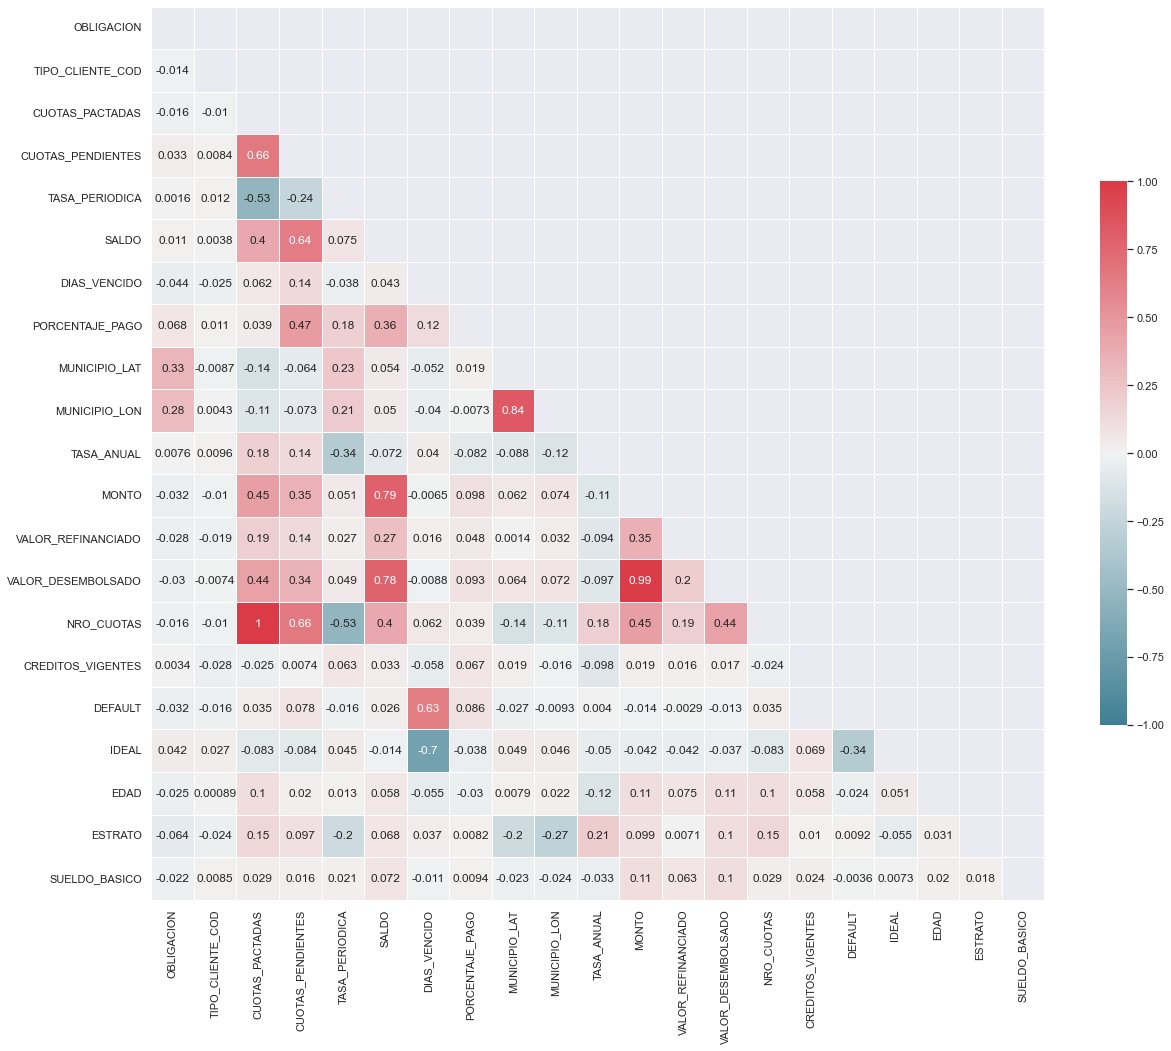

In [24]:
#compute correlation matrix
df_correlations = model_df.corr()

#mask the upper half for visualization purposes
mask = np.zeros_like(df_correlations, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize= (20,20))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_correlations,
            mask=mask,  
            vmax=1, 
            vmin=-1, 
            cmap=cmap, 
            center=0,
            annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Split our data into training and testing sets (an 80-20 split is a good starting point):

In [25]:
np.random.seed(1234) # a seed makes the analysis reproducible
                     # so everyone will get the same results

n_data = len(model_df)

# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(n_data), int(0.7*n_data), replace=False)

# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(n_data)) - set(idx_train)))

df_train     = model_df.iloc[idx_train] # the training data set
df_test      = model_df.iloc[idx_test]  # the test data set

print(df_train.shape) 
print(df_test.shape)  

(27048, 85)
(11593, 85)


In [26]:
len(df_train.loc[df_train['DEFAULT'] == 1])

679

In [27]:
len(df_train.loc[df_train['DEFAULT'] == 0])

26369

In [28]:
df_train.shape

(27048, 85)

In [29]:
df_train.dropna().shape

(2956, 85)

In [30]:
len(df_train.loc[df_train['IDEAL'] == 1])

22262

In [31]:
len(df_train.loc[df_train['IDEAL'] == 0])

4786

In [32]:
len(df_test.loc[df_test['IDEAL'] == 1])

9446

In [33]:
len(df_test.loc[df_test['IDEAL'] == 0])

2147

<H2> MODEL 2: Logistic Regression </H2>

Classification model for predicting if a client is going to be in default as a binary or binomial classification:

See: https://realpython.com/logistic-regression-python/

Week 7 - case.cross_validation_fellow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [ ]:
def fit_logistic_regression(X,y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    # Create model and fit (or train) model
    clf = LogisticRegression(solver='saga',                             
                             tol=10**-4,
                             max_iter = 4000,
                             fit_intercept=True,
                             multi_class='multinomial'
                            ).fit(X,y)
    return clf

In [ ]:
# we will use a 70%/30% split for training/validation
n_total = len(model_df)
n_train = int(0.7*n_total)

X, y = model_df[['EDAD']], model_df.IDEAL
X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [67]:
X_train.shape[0] != y_train.shape[0]

False

In [68]:
X_train.shape , y_train.shape

((27048, 1), (27048,))

In [69]:
model_reg = fit_logistic_regression(X_train, y_train)  # fit a logistic regression

Check model's performance with .predict_proba(), which returns the matrix of probabilities that the predicted output is equal to zero or one:

In [70]:
y_test_pred = model_reg.predict_proba(X_test)[:,1]     # make probabilistic predictions on test set
y_test_pred

array([0.81306194, 0.81164491, 0.80589436, ..., 0.83073955, 0.80001149,
       0.80589436])

ROC curve of model_reg and find the area under the curve:

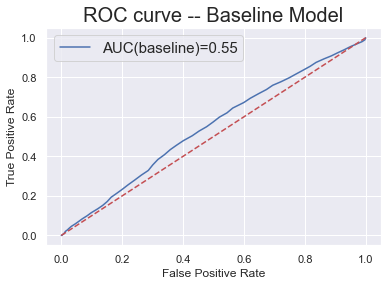

In [71]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)  #compute FPR/TPR
auc_baseline = auc(fpr, tpr) # compute AUC

plt.plot(fpr, tpr, "b-", label="AUC(baseline)={:2.2f}".format(auc_baseline))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=15)
plt.plot([0,1], [0,1], "r--")
plt.title("ROC curve -- Baseline Model", fontsize=20);

The attribute .classes_ represents the array of distinct values that y takes:

In [72]:
model_reg.classes_

array([0, 1], dtype=int64)

Get the value of the slope 𝑏₁ and the intercept 𝑏₀ of the linear function 𝑓 like so:

In [73]:
model_reg.intercept_

array([0.56303943])

In [74]:
model_reg.coef_

array([[0.00464799]])

In [75]:
model_reg.predict(X)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [76]:
model_reg.score(X, y)

0.8205791775575166

We can get information on the accuracy of the model with a confusion matrix. In the case of binary classification, the confusion matrix shows the numbers of the following:

- True negatives in the upper-left position
- False negatives in the lower-left position
- False positives in the upper-right position
- True positives in the lower-right position

In [77]:
confusion_matrix(y, model_reg.predict(X))

array([[    0,  6933],
       [    0, 31708]], dtype=int64)

The obtained matrix shows the following:

37678 true negative predictions: The first 37678 observations are zeros predicted correctly.
963 false negative predictions: These are the ones wrongly predicted as zeros.
0 false positive prediction: The 0 observation is a zero that was wrongly predicted as one.
0 true positive predictions: The last 0 observations are ones predicted correctly.

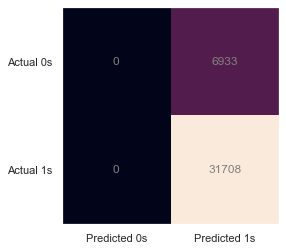

In [102]:
cm = confusion_matrix(y, model_reg.predict(X))

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='Gray')
plt.show()

In [79]:
print(classification_report(y, model_reg.predict(X)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6933
           1       0.82      1.00      0.90     31708

    accuracy                           0.82     38641
   macro avg       0.41      0.50      0.45     38641
weighted avg       0.67      0.82      0.74     38641



C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross-validation

skf = StratifiedKFold(n_splits=10)
for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
    plt.plot(train_index, [k+1 for _ in train_index], ".")
plt.ylim(0,12)
plt.ylabel("FOLD")
plt.title("CROSS VALIDATION FOLDS")

In [80]:
def fit_logistic_regression(X, y):
    """
    fit a logistic regression with feature matrix X and binary output y
    """
    # Create model and fit (or train) model
    clf = LogisticRegression(solver='saga',                             
                             tol=10**-4,
                             max_iter = 1000,
                             fit_intercept=True,
                             multi_class='multinomial'
                            ).fit(X,y)
    return clf

In [81]:
def compute_AUC(X, y, train_index, test_index):
    """
    feature/output: X, y
    dataset split: train_index, test_index
    """
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf = fit_logistic_regression(X_train, y_train)
    default_proba_test = clf.predict_proba(X_test)[:,1]  
    fpr, tpr, _ = roc_curve(y_test, default_proba_test)
    auc_score = auc(fpr, tpr)
    return auc_score, fpr, tpr

In [82]:
def cross_validation_AUC(X,y, nfold=5):
    """
    use a n-fold cross-validation for computing AUC estimates
    """
    skf = StratifiedKFold(n_splits=nfold)  #create a cross-validation splitting
    auc_list = [] #this list will contain the AUC estimates associated with each fold
    for k, (train_index, test_index) in enumerate( skf.split(X, y) ):
        auc_score, _, _ = compute_AUC(X, y, train_index, test_index)
        auc_list.append(auc_score)
    return auc_list

We will now estimate and compare, through cross-validation analysis, the performance of all the "simple models" that only use one numerical feature as input. We will use the logarithmic transform for the loan_amount variable:

In [103]:
# let us extract only the numerical (i.e non-categorical) features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
Data_numerics = model_df.select_dtypes(include=numerics)
Data_numerics = Data_numerics.drop(["OBLIGACION", "TIPO_CLIENTE_COD", 
                                    "CUOTAS_PENDIENTES", "DIAS_VENCIDO", 
                                    "PORCENTAJE_PAGO", "VALOR_REFINANCIADO",
                                    "VALOR_DESEMBOLSADO", "NRO_CUOTAS",
                                    "SALDO", "CREDITOS_VIGENTES", "DEFAULT"
                                   ], axis=1)
Data_numerics

,CUOTAS_PACTADAS,TASA_PERIODICA,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,IDEAL,EDAD,ESTRATO,SUELDO_BASICO
0,12,2.64,4.85430,-73.04003,31.67,2000000,1,51,1.0,0.0
1,36,2.94,4.14200,-73.62664,35.29,6000000,1,48,2.0,0.0
2,24,2.94,3.98695,-73.75797,35.29,2950000,1,53,2.0,0.0
3,24,2.94,3.54625,-73.70687,35.29,2900000,1,50,2.0,1400000.0
4,12,2.94,4.87802,-72.89575,35.29,1000000,1,73,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
38636,1,9.08,6.46065,-71.73618,35.28,1000000,1,54,1.0,0.0
38637,24,3.20,6.46065,-71.73618,38.40,6000000,1,34,1.0,0.0
38638,1,9.08,6.46065,-71.73618,35.28,1000000,1,50,1.0,3000000.0
38639,6,8.13,6.46065,-71.73618,31.68,4000000,1,28,1.0,0.0


In [104]:
Data_numerics.shape

(38641, 10)

In [105]:
Data_numerics = Data_numerics.dropna()
null_eda = Data_numerics.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos


In [106]:
# Using a log scale when appropriate
#Data_numerics["SUELDO_BASICO"] = np.log10(Data_numerics["SUELDO_BASICO"])
idx = Data_numerics["MONTO"] >= 0
Data_numerics.loc[idx,"MONTO"] = np.log10(Data_numerics["MONTO"])
#Data_numerics["avg_cur_bal"] = np.log10(1.+Data_numerics["avg_cur_bal"])
Data_numerics

C:\Users\mchah\AppData\Local\Temp\ipykernel_26884\863937088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_numerics.loc[idx,"MONTO"] = np.log10(Data_numerics["MONTO"])


,CUOTAS_PACTADAS,TASA_PERIODICA,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,IDEAL,EDAD,ESTRATO,SUELDO_BASICO
0,12,2.64,4.85430,-73.04003,31.67,6.301030,1,51,1.0,0.0
1,36,2.94,4.14200,-73.62664,35.29,6.778151,1,48,2.0,0.0
2,24,2.94,3.98695,-73.75797,35.29,6.469822,1,53,2.0,0.0
3,24,2.94,3.54625,-73.70687,35.29,6.462398,1,50,2.0,1400000.0
4,12,2.94,4.87802,-72.89575,35.29,6.000000,1,73,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
38636,1,9.08,6.46065,-71.73618,35.28,6.000000,1,54,1.0,0.0
38637,24,3.20,6.46065,-71.73618,38.40,6.778151,1,34,1.0,0.0
38638,1,9.08,6.46065,-71.73618,35.28,6.000000,1,50,1.0,3000000.0
38639,6,8.13,6.46065,-71.73618,31.68,6.602060,1,28,1.0,0.0


Let's compute cross-validation estimates of the AUC for each single-feature model:

In [107]:
model_perf = pd.DataFrame({}) #this data-frame will contain the AUC estimates
for key in Data_numerics.keys():
    #if key == "DEFAULT": continue
    if key == "IDEAL": continue
    print(key)
    #X_full, y_full = Data_numerics[[key]], Data_numerics.DEFAULT
    X_full, y_full = Data_numerics[[key]], Data_numerics.IDEAL
    auc_list = cross_validation_AUC(X_full, y_full, nfold=5)
    model_perf["SIMPLE:" + key] = auc_list

CUOTAS_PACTADAS
TASA_PERIODICA
MUNICIPIO_LAT
MUNICIPIO_LON


C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TASA_ANUAL
MONTO
EDAD
ESTRATO
SUELDO_BASICO


Show the distribution of cross-validation scores of each variable (each variable has 10 total scores). Which feature has the highest/lowest predictive power?

In [98]:
def plot_boxplot_ordered(df_model):
    """
    display a list of boxplot, ordered by the media values
    """
    df = df_model[df_model.median().sort_values().index]
    sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)
    plt.xticks(rotation=90)

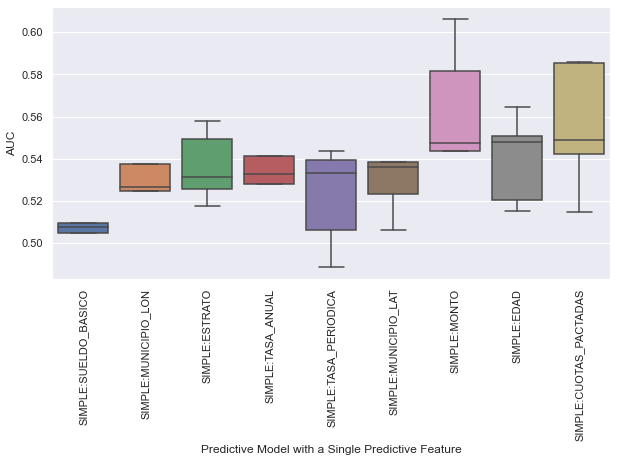

In [99]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

____

In [118]:
#X_full, y_full = Data_numerics.drop(["DEFAULT"], axis=1), Data_numerics.DEFAULT
X_full, y_full = Data_numerics.drop(["IDEAL"], axis=1), Data_numerics.IDEAL
auc_list = cross_validation_AUC(X_full, y_full)
model_perf["ALL_NUMERICAL"] = auc_list
model_perf

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,SIMPLE:CUOTAS_PACTADAS,SIMPLE:TASA_PERIODICA,SIMPLE:MUNICIPIO_LAT,SIMPLE:MUNICIPIO_LON,SIMPLE:TASA_ANUAL,SIMPLE:MONTO,SIMPLE:EDAD,SIMPLE:ESTRATO,SIMPLE:SUELDO_BASICO,ALL_NUMERICAL
0,0.585461,0.488802,0.523319,0.473622,0.532708,0.547632,0.564541,0.531161,0.525931,0.561454
1,0.542304,0.505986,0.506296,0.501100,0.455237,0.543825,0.547828,0.517327,0.507676,0.545109
2,0.585763,0.539341,0.536056,0.524434,0.563828,0.606139,0.520570,0.525619,0.509324,0.498560
3,0.549027,0.543712,0.538502,0.537673,0.527876,0.581613,0.515170,0.558094,0.495023,0.489678
4,0.514466,0.533145,0.569077,0.585131,0.541077,0.479288,0.551011,0.549208,0.504916,0.529625


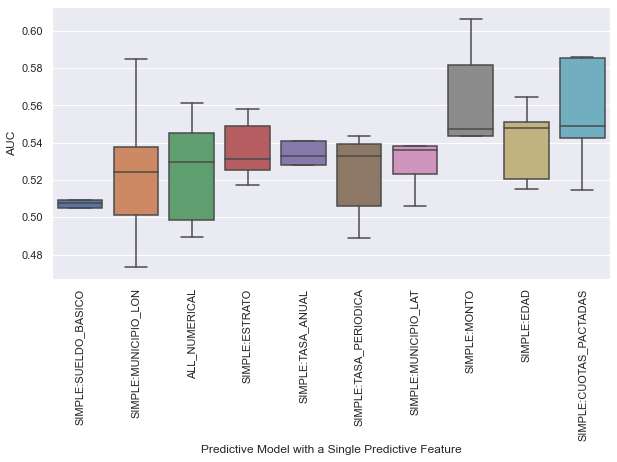

In [119]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

## Incorporating categorical variables

Calificación Peor:

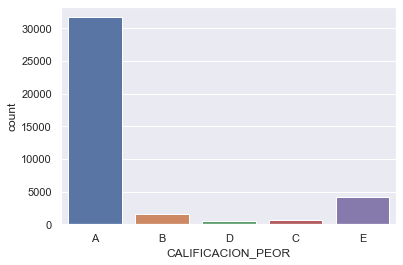

In [60]:
sns.countplot(x='CALIFICACION_PEOR', data = model_df);

In [61]:
#use a one-hot-encoding approach for incorporating the "grade" categorical variable
grade_worse = pd.get_dummies(model_df['CALIFICACION_PEOR'], prefix = "worse", drop_first=True)
grade_worse.head()

,worse_B,worse_C,worse_D,worse_E
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [62]:
X_worse = pd.concat([X_full, grade_worse],axis=1) 
X_worse.head()

,CUOTAS_PACTADAS,TASA_PERIODICA,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,EDAD,ESTRATO,SUELDO_BASICO,worse_B,worse_C,worse_D,worse_E
0,12.0,2.64,4.85430,-73.04003,31.67,6.301030,51.0,1.0,0.0,0,0,0,0
1,36.0,2.94,4.14200,-73.62664,35.29,6.778151,48.0,2.0,0.0,0,0,0,0
2,24.0,2.94,3.98695,-73.75797,35.29,6.469822,53.0,2.0,0.0,0,0,0,0
3,24.0,2.94,3.54625,-73.70687,35.29,6.462398,50.0,2.0,1400000.0,0,0,0,0
4,12.0,2.94,4.87802,-72.89575,35.29,6.000000,73.0,1.0,0.0,0,0,0,0


In [63]:
X_worse = X_worse.dropna()
null_eda = X_worse.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_worse.shape

,index,Nulos


In [67]:
auc_list = cross_validation_AUC(X_worse, y_full)
model_perf["ALL_NUMERICAL_WITH_WORSE_GRADE"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which 

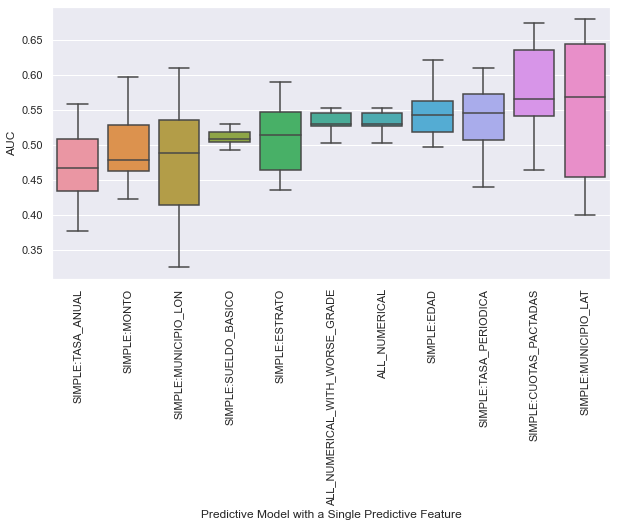

In [68]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

_________________

Calificación de Cierre

The grade of a loan (i.e. the LC-assigned loan grade feature) has not been used so far. The following is the distribution of the categorical grade feature:

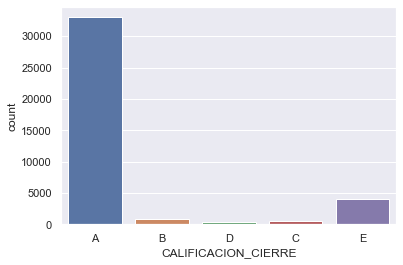

In [120]:
sns.countplot(x='CALIFICACION_CIERRE', data = model_df);

In [121]:
#use a one-hot-encoding approach for incorporating the "grade" categorical variable
grade_categ = pd.get_dummies(model_df['CALIFICACION_CIERRE'], prefix = "grade", drop_first=True)
grade_categ.head()

,grade_B,grade_C,grade_D,grade_E
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [122]:
X_grade = pd.concat([X_full, grade_categ],axis=1) 
X_grade.head()

,CUOTAS_PACTADAS,TASA_PERIODICA,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,EDAD,ESTRATO,SUELDO_BASICO,grade_B,grade_C,grade_D,grade_E
0,12.0,2.64,4.85430,-73.04003,31.67,6.301030,51.0,1.0,0.0,0,0,0,0
1,36.0,2.94,4.14200,-73.62664,35.29,6.778151,48.0,2.0,0.0,0,0,0,0
2,24.0,2.94,3.98695,-73.75797,35.29,6.469822,53.0,2.0,0.0,0,0,0,0
3,24.0,2.94,3.54625,-73.70687,35.29,6.462398,50.0,2.0,1400000.0,0,0,0,0
4,12.0,2.94,4.87802,-72.89575,35.29,6.000000,73.0,1.0,0.0,0,0,0,0


In [123]:
X_grade = X_grade.dropna()
null_eda = X_grade.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]

,index,Nulos


In [124]:
auc_list = cross_validation_AUC(X_grade, y_full)
model_perf["ALL_NUMERICAL_WITH_GRADE"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


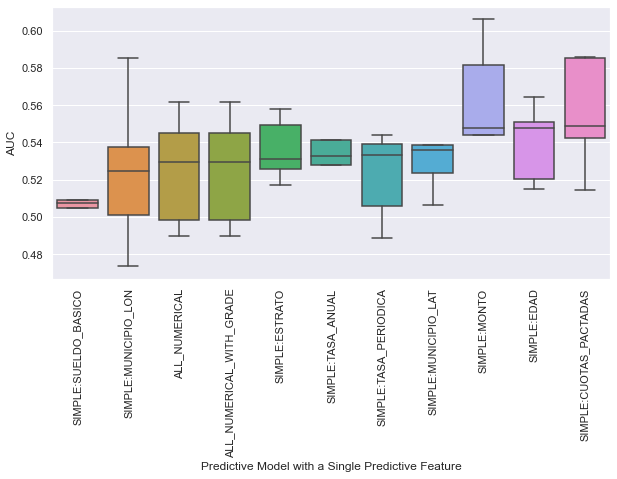

In [125]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

______

Homeownership:

In [126]:
#use a one-hot-encoding approach for incorporating the "TIPO_VIVIENDA" categorical variable
homeownership_categ = pd.get_dummies(model_df['TIPO_VIVIENDA'], prefix = "homeownership", drop_first=True)
homeownership_categ.head()

,homeownership_FAMILIAR,homeownership_HIPOTECA,homeownership_OTRA,homeownership_PROPIA,homeownership_SIN_VIVIENDA
0,0,0,0,0,0
1,0,0,1,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,1,0


In [127]:
X_homeownership = pd.concat([X_grade, homeownership_categ], axis=1) 
X_homeownership.head()

,CUOTAS_PACTADAS,TASA_PERIODICA,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,EDAD,ESTRATO,SUELDO_BASICO,grade_B,grade_C,grade_D,grade_E,homeownership_FAMILIAR,homeownership_HIPOTECA,homeownership_OTRA,homeownership_PROPIA,homeownership_SIN_VIVIENDA
0,12.0,2.64,4.85430,-73.04003,31.67,6.301030,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,36.0,2.94,4.14200,-73.62664,35.29,6.778151,48.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
2,24.0,2.94,3.98695,-73.75797,35.29,6.469822,53.0,2.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
3,24.0,2.94,3.54625,-73.70687,35.29,6.462398,50.0,2.0,1400000.0,0.0,0.0,0.0,0.0,0,0,0,0,0
4,12.0,2.94,4.87802,-72.89575,35.29,6.000000,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0


In [128]:
X_homeownership = X_homeownership.dropna()
null_eda = X_homeownership.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_homeownership.shape

(38502, 18)

In [129]:
auc_list = cross_validation_AUC(X_homeownership, y_full)
model_perf["ALL_NUMERICAL_WITH_HOMEOWNERSHIP"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


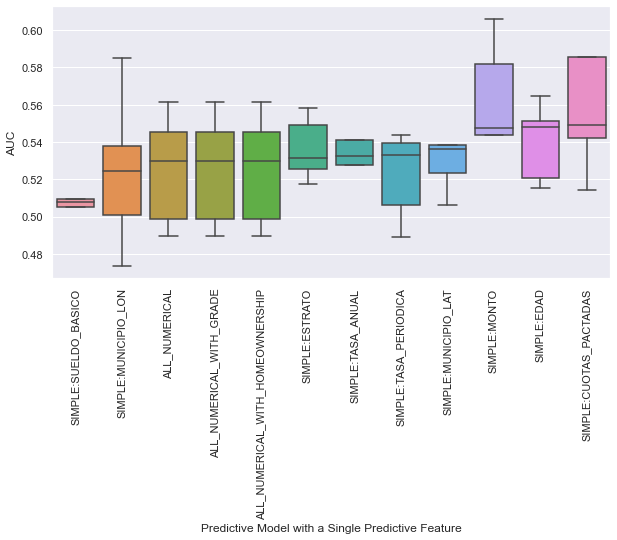

In [130]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

_____

Estado Civil:

In [131]:
#use a one-hot-encoding approach for incorporating the "TIPO_VIVIENDA" categorical variable
maritalstatus_categ = pd.get_dummies(model_df['ESTADO_CIVIL'], prefix = "marital_status", drop_first=True)
maritalstatus_categ.head()

,marital_status_Divorciado,marital_status_Otro,marital_status_Soltero,marital_status_Union libre,marital_status_Viudo
0,0,0,0,1,0
1,0,0,0,0,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,0,0,0


In [132]:
X_maritalstatus = pd.concat([X_homeownership, maritalstatus_categ], axis=1) 
X_maritalstatus.head()

,CUOTAS_PACTADAS,TASA_PERIODICA,MUNICIPIO_LAT,MUNICIPIO_LON,TASA_ANUAL,MONTO,EDAD,ESTRATO,SUELDO_BASICO,grade_B,grade_C,grade_D,grade_E,homeownership_FAMILIAR,homeownership_HIPOTECA,homeownership_OTRA,homeownership_PROPIA,homeownership_SIN_VIVIENDA,marital_status_Divorciado,marital_status_Otro,marital_status_Soltero,marital_status_Union libre,marital_status_Viudo
0,12.0,2.64,4.85430,-73.04003,31.67,6.301030,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
1,36.0,2.94,4.14200,-73.62664,35.29,6.778151,48.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0
2,24.0,2.94,3.98695,-73.75797,35.29,6.469822,53.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,1,0
3,24.0,2.94,3.54625,-73.70687,35.29,6.462398,50.0,2.0,1400000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
4,12.0,2.94,4.87802,-72.89575,35.29,6.000000,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0


In [133]:
X_maritalstatus = X_maritalstatus.dropna()
null_eda = X_maritalstatus.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_maritalstatus.shape

(38502, 23)

In [134]:
auc_list = cross_validation_AUC(X_maritalstatus, y_full)
model_perf["ALL_NUMERICAL_WITH_MARITAL_STATUS"] = auc_list

C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Anaconda\envs\ds4a\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


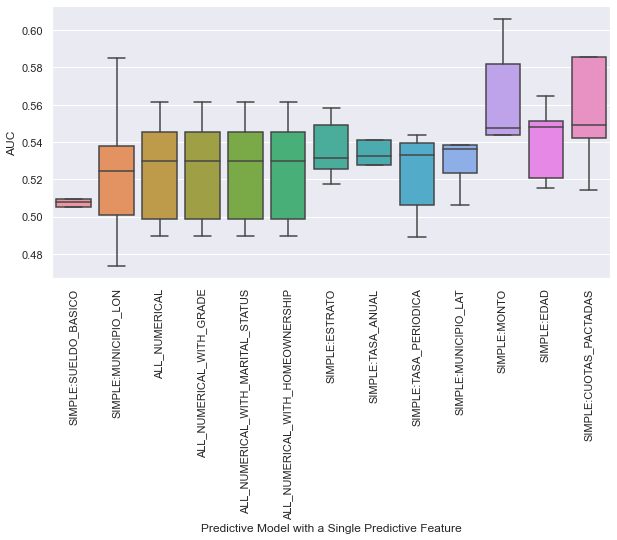

In [135]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");

_______________

Oficio:

In [ ]:
X_job.keys()
# --> n features

In [ ]:
#use a one-hot-encoding approach for incorporating the "OFICIO" categorical variable
job_categ = pd.get_dummies(model_df['OFICIO'], prefix = "job", drop_first=True)
job_categ.head()

X_job = pd.concat([X_maritalstatus, job_categ], axis=1) 
X_job.head()

X_job = X_job.dropna()
null_eda = X_maritalstatus.isnull().sum().to_frame(name='Nulos').reset_index()
null_eda[null_eda['Nulos'] > 0]
X_job.shape

auc_list = cross_validation_AUC(X_job, y_full)
model_perf["ALL_NUMERICAL_WITH_JOB"] = auc_list

In [ ]:
plt.figure(figsize= (10,5))
plot_boxplot_ordered(model_perf)
plt.xlabel("Predictive Model with a Single Predictive Feature")
plt.ylabel("AUC");